<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250716/k%E3%83%A1%E3%83%87%E3%82%A3%E3%82%A2%E3%83%B3%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###準備
20250716

In [ ]:
%%capture
# python-mip ライブラリをインストールする
!pip install mip

# Matplotlibで日本語を表示するためのライブラリをインストール
!pip install japanize-matplotlib >/dev/null

# 必要なライブラリをインポートする
import mip
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # ← 日本語表示のためにインポート
import random
from math import sqrt
from itertools import product
from scipy.spatial.distance import cdist # 距離行列計算用

#k-メディアン問題

本講義では、
**k-メディアン問題 (k-Median Problem)**
について学びます。
この問題は、限られた数の施設（例えば、倉庫、店舗、公共サービス拠点など）をどこに配置すれば、顧客や利用者へのサービス提供コスト（多くは移動距離や時間）を全体として最小化できるか、という課題に取り組みます。

k-メディアン問題は、物流ネットワークの設計、公共サービスの効率化、商業エリアの最適化、さらにはデータクラスタリングなど、多岐にわたる分野でその応用が見られます。与えられた数の施設を「最適」に配置することで、経済的効率性や社会的便益を最大化することを目指します。

本講義の目標は以下の通りです。

1.  k-メディアン問題の基本的な概念、その戦略的重要性、および実社会での応用例を理解する。
2.  k-メディアン問題を数理モデル（整数計画問題）として正確に定式化する手法を習得する。
3.  Pythonの最適化ライブラリ `python-mip` を用いてk-メディアン問題を実際に解き、その結果を解釈する技術を身につける。
4.  k-メディアン問題の計算的側面や、関連する施設配置問題について考察する。
5.  提示された課題を通じて、問題解決能力と応用力を養う。


## k-メディアン問題の定義

k-メディアン問題は、与えられた複数の施設建設候補地の中から
**$k$ 個の施設**を建設し、
与えられた複数の需要地点（顧客やサービスの受け手が存在する場所）をいずれか一つの開設された施設に割り当てることで、
**全需要地点から割り当てられた施設までの総距離（または総コスト）を最小化する**問題である。

多くの場合、需要地点の集合と施設建設候補地の集合は同一である（つまり、顧客がいる場所に施設を建てることができる）と仮定される。

k-メディアン問題は、一般的に以下のように定義される。

  * **入力**:
      * 需要地点の集合
  $I = \{0, 1, \dots, n-1\}$
      * 施設建設候補地の集合
  $J = \{0, 1, \dots, m-1\}$ （本講義では簡単のため $I=J$ とし、$n=m$ とする。つまり、各需要地点が施設建設候補地にもなり得るとする）
      * 各需要地点 $i \\in I$ から各施設建設候補地 $j \\in J$ への距離またはコスト $d\_{ij}$
      * 開設する施設の数 $k$
  * **出力**:
      * 開設する $k$ 個の施設の位置の決定
      * 各需要地点を、開設された $k$ 個の施設のうちのいずれか一つに割り当てる方法
  * **目的**:
      * 全ての需要地点から、それぞれ割り当てられた施設までの総距離（または総コスト）の最小化

この問題は、組み合わせ最適化問題の一種であり、
問題規模（需要地の個数）が増加するととともに最適化に必要な計算が非常に増加し、
最適解を得ることが困難になる
**NP困難**な問題として知られている。

## 簡単な例題と図解

6つの需要地点 (0から5) があり、これらの中から $k=2$ 個の施設（メディアン）を選び、各需要地点を最も近い選ばれた施設に割り当てることで、総割り当て距離を最小にすることを考える。

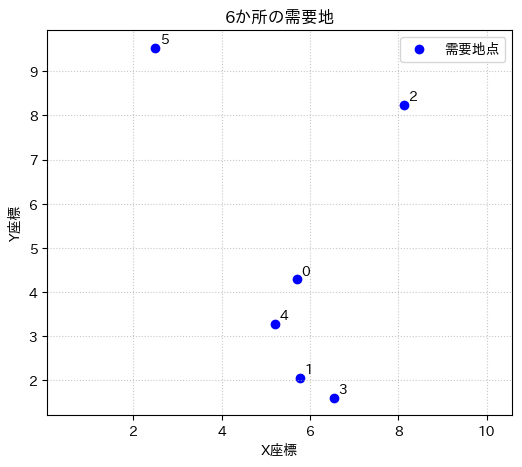

In [ ]:
#@title 例題の図
num_demand_points_ex = 6
k_facilities_ex = 2
random.seed(10) # 再現性のため
demand_coords_ex = np.array([(random.uniform(0,10), random.uniform(0,10)) for _ in range(num_demand_points_ex)])

# 距離行列 (ユークリッド距離)
dist_matrix_ex = cdist(demand_coords_ex, demand_coords_ex, 'euclidean')

# 図示のための準備
plt.figure(figsize=(6,5))
plt.scatter(demand_coords_ex[:,0], demand_coords_ex[:,1], c='blue', label='需要地点')
for i in range(num_demand_points_ex):
    plt.text(demand_coords_ex[i,0]+0.1, demand_coords_ex[i,1]+0.1, str(i))

# 例: 施設を地点0と地点3に建設した場合
facility_locations_ex = []
assignments_ex = {}
total_dist_ex = 0

plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title(f"6か所の需要地")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.axis('equal')
plt.show()

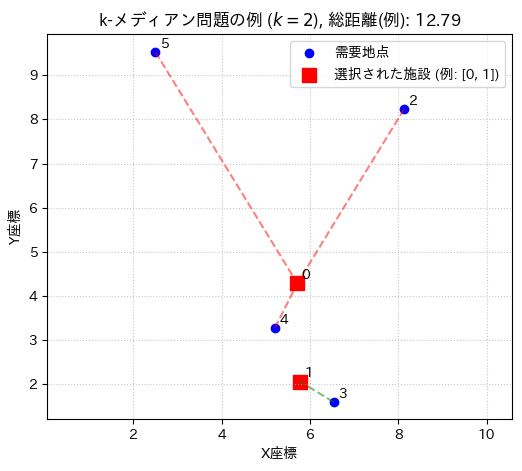

In [ ]:
#@title 施設を地点0と1に建設した例
num_demand_points_ex = 6
k_facilities_ex = 2
random.seed(10) # 再現性のため
demand_coords_ex = np.array([(random.uniform(0,10), random.uniform(0,10)) for _ in range(num_demand_points_ex)])

# 距離行列 (ユークリッド距離)
dist_matrix_ex = cdist(demand_coords_ex, demand_coords_ex, 'euclidean')

# 図示のための準備
plt.figure(figsize=(6,5))
plt.scatter(demand_coords_ex[:,0], demand_coords_ex[:,1], c='blue', label='需要地点')
for i in range(num_demand_points_ex):
    plt.text(demand_coords_ex[i,0]+0.1, demand_coords_ex[i,1]+0.1, str(i))

# 例: 施設を地点0と地点3に建設した場合
facility_locations_ex = [0, 1]
assignments_ex = {}
total_dist_ex = 0

# 各需要地点を最も近い施設に割り当て
for i in range(num_demand_points_ex):
    dist_to_fac0 = dist_matrix_ex[i, facility_locations_ex[0]]
    dist_to_fac3 = dist_matrix_ex[i, facility_locations_ex[1]]
    if dist_to_fac0 <= dist_to_fac3:
        assigned_fac = facility_locations_ex[0]
        assignments_ex[i] = assigned_fac
        total_dist_ex += dist_to_fac0
        plt.plot([demand_coords_ex[i,0], demand_coords_ex[assigned_fac,0]],
                 [demand_coords_ex[i,1], demand_coords_ex[assigned_fac,1]], 'r--', alpha=0.5)
    else:
        assigned_fac = facility_locations_ex[1]
        assignments_ex[i] = assigned_fac
        total_dist_ex += dist_to_fac3
        plt.plot([demand_coords_ex[i,0], demand_coords_ex[assigned_fac,0]],
                 [demand_coords_ex[i,1], demand_coords_ex[assigned_fac,1]], 'g--', alpha=0.5)

plt.scatter(demand_coords_ex[facility_locations_ex,0], demand_coords_ex[facility_locations_ex,1],
            c='red', marker='s', s=100, label=f'選択された施設 (例: {facility_locations_ex})')

plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title(f"k-メディアン問題の例 ($k={k_facilities_ex}$), 総距離(例): {total_dist_ex:.2f}")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.axis('equal')
plt.show()

#print(f"需要地点の座標:\n{demand_coords_ex}")
#print(f"需要地点の座標:\n{np.round(demand_coords_ex, 2)}")
#print(f"\n例として施設を地点 {facility_locations_ex} に建設した場合:")
#print(f"  各需要地点の割り当て先: {assignments_ex}")
#print(f"  この割り当てでの総距離: {total_dist_ex:.2f}")

**図の説明**:
青い点が需要地点（兼施設候補地）を示す。
この図は、赤い四角で示された地点0と地点1に施設を建設した場合である。
各需要地点は、最も近い開設された施設に割り当てられ（点線）、
その総割り当て距離が計算される。
k-メディアン問題の目的は、
この総距離が最小となるような $k$ 個の施設の組み合わせとそれに対応する割り当てを見つけることである。


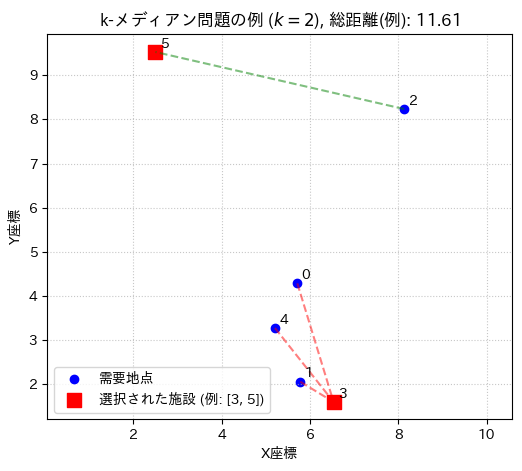

In [ ]:
#@title 施設を地点3と5に建設した例
num_demand_points_ex = 6
k_facilities_ex = 2
random.seed(10) # 再現性のため
demand_coords_ex = np.array([(random.uniform(0,10), random.uniform(0,10)) for _ in range(num_demand_points_ex)])

# 距離行列 (ユークリッド距離)
dist_matrix_ex = cdist(demand_coords_ex, demand_coords_ex, 'euclidean')

# 図示のための準備
plt.figure(figsize=(6,5))
plt.scatter(demand_coords_ex[:,0], demand_coords_ex[:,1], c='blue', label='需要地点')
for i in range(num_demand_points_ex):
    plt.text(demand_coords_ex[i,0]+0.1, demand_coords_ex[i,1]+0.1, str(i))

# 例: 施設を地点0と地点3に建設した場合
facility_locations_ex = [3, 5]
assignments_ex = {}
total_dist_ex = 0

# 各需要地点を最も近い施設に割り当て
for i in range(num_demand_points_ex):
    dist_to_fac0 = dist_matrix_ex[i, facility_locations_ex[0]]
    dist_to_fac3 = dist_matrix_ex[i, facility_locations_ex[1]]
    if dist_to_fac0 <= dist_to_fac3:
        assigned_fac = facility_locations_ex[0]
        assignments_ex[i] = assigned_fac
        total_dist_ex += dist_to_fac0
        plt.plot([demand_coords_ex[i,0], demand_coords_ex[assigned_fac,0]],
                 [demand_coords_ex[i,1], demand_coords_ex[assigned_fac,1]], 'r--', alpha=0.5)
    else:
        assigned_fac = facility_locations_ex[1]
        assignments_ex[i] = assigned_fac
        total_dist_ex += dist_to_fac3
        plt.plot([demand_coords_ex[i,0], demand_coords_ex[assigned_fac,0]],
                 [demand_coords_ex[i,1], demand_coords_ex[assigned_fac,1]], 'g--', alpha=0.5)

plt.scatter(demand_coords_ex[facility_locations_ex,0], demand_coords_ex[facility_locations_ex,1],
            c='red', marker='s', s=100, label=f'選択された施設 (例: {facility_locations_ex})')

plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title(f"k-メディアン問題の例 ($k={k_facilities_ex}$), 総距離(例): {total_dist_ex:.2f}")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.axis('equal')
plt.show()

#print(f"需要地点の座標:\n{demand_coords_ex}")
#print(f"需要地点の座標:\n{np.round(demand_coords_ex, 2)}")
#print(f"\n例として施設を地点 {facility_locations_ex} に建設した場合:")
#print(f"  各需要地点の割り当て先: {assignments_ex}")
#print(f"  この割り当てでの総距離: {total_dist_ex:.2f}")

##実社会での応用例

k-メディアン問題の考え方は、様々な分野で最適な配置決定に役立てられている。

  * **公共施設の配置**:
      * 学校、病院、図書館、消防署、警察署、郵便局、投票所など、住民がアクセスしやすいように、また総移動距離や時間を最小にするように配置する。
  * **商業施設の配置**:
      * 店舗（小売店、スーパーマーケット）、銀行の支店やATM、レストランなどを、顧客の利便性を高め、集客を最大化する（来店コストを最小化する）ように配置する。
      * 倉庫や配送センターを、顧客や小売店への配送総コストを最小化するように配置する（これはTSPやVRPと組み合わさることも多い）。
  * **データクラスタリング**:
      * データ点の集合を $k$ 個のクラスタに分割する際、各クラスタの「中心」（メディアンまたはメドイド）を選び、各データ点を最も近い中心に割り当てることで、クラスタ内の誤差平方和（に類する距離の総和）を最小化する。k-meansクラスタリングと関連が深い。
  * **通信ネットワーク**:
      * サーバー、ルーター、無線基地局などを、ユーザーへのアクセス遅延や通信コストの総和を最小にするように配置する。
  * **資源配分**:
      * 緊急救援物資の集積所を $k$ 箇所選び、被災地への輸送コストを最小化する。

これらの応用において、k-メディアン問題の解法は、コスト削減、サービス品質向上、効率的な資源利用に貢献する。

## 数理モデルによる定式化

k-メディアン問題を整数計画問題として定式化する。

### パラメータ（定数）

  * $I = \{0, 1, \dots, n-1\}$: 需要地点の集合（$n$ は需要地点の総数）。
  * $J = \{0, 1, \dots, m-1\}$: 施設建設候補地の集合（$m$ は候補地の総数）。
      * ここでは簡単のため、$I=J$ とし、$n=m$ とする。つまり、各需要地点の場所に施設を建設できると仮定する。
  * $d_{ij}$: 需要地点 $i$ から施設候補地 $j$ への距離またはコスト。
  * $k$: 開設する施設の数。

### 決定変数

  * $y_j$: 施設建設候補地 $j \in J$ に施設を開設するならば $1$、
  そうでないならば $0$ をとるバイナリ変数。
  * $x_{ij}$: 需要地点 $i \in I$ を、施設建設候補地 $j \in J$ に開設された施設に割り当てるならば $1$、そうでないならば $0$ をとるバイナリ変数。

### 目的関数

全ての需要地点から、それぞれ割り当てられた施設までの総距離（または総コスト）を最小化する。

$$\min \sum_{i \in I} \sum_{j \in J} d_{ij} x_{ij}$$

### 制約条件

1.  **割り当て制約**:
各需要地点 $i$ は、いずれか一つの施設 $j$ に割り当てられなければならない。
$$\sum_{j \in J} x_{ij} = 1 \quad \forall i \in I$$

2.  **施設開設連動制約**:
    需要地点 $i$ を施設候補地 $j$ に割り当てる ($x\_{ij}=1$) ことができるのは、その候補地 $j$ に実際に施設が開設されている ($y\_j=1$) 場合のみである。
    $$x_{ij} \le y_j \quad \forall i \in I, \forall j \in J$$
    もし $y\_j=0$ (施設 $j$ が開設されない) ならば、全ての $i$ について $x\_{ij}=0$ となり、需要地点 $i$ は施設 $j$ に割り当てられない。もし $y\_j=1$ ならば、$x\_{ij} \\le 1$ となり、割り当てが可能になる。

3.  **施設数制約**:
    開設される施設の総数は、指定された数 $k$ に等しくなければならない。
    $$\sum_{j \in J} y_j = k$$

4.  **変数型制約**:
    全ての決定変数はバイナリ（0または1）である。
$$x_{ij} \in \{0, 1\} \quad \forall i \in I, \forall j \in J$$
$$y_j \in \{0, 1\} \quad \forall j \in J$$

### 数理モデルのまとめ

**目的関数**:
$$\min \sum_{i \in I} \sum_{j \in J} d_{ij} x_{ij}$$

**制約条件**:

1.  $\sum_{j \in J} x_{ij} = 1 \quad \forall i \in I$
2.  $x_{ij} \le y_j \quad \forall i \in I, \forall j \in J$
3.  $\sum_{j \in J} y_j = k$
4.  $x_{ij} \in \{0, 1\} \quad \forall i \in I, \forall j \in J$
5.  $y_j \in \{0, 1\} \quad \forall j \in J$

この定式化により、k-メディアン問題を整数計画ソルバーで解くことが可能になる。

## Python MIP を用いた実装

`python-mip` ライブラリを用いて、上記のk-メディアン問題を解く。
需要地点の座標をランダムに生成し、施設候補地も同じ地点とする。距離はユークリッド距離を用いる。

###パラメータ（定数）の設定

In [ ]:
# 地点数 (需要地点数 = 施設候補地数)
num_locations = 15 # 例として15地点
k_to_locate = 3    # 開設する施設数

# 地点の座標を 0から100の範囲でランダムに生成
random.seed(50) # 再現性のためのシード
locations_coords = np.array([(random.uniform(0,100), random.uniform(0,100)) for _ in range(num_locations)])

# 距離行列の計算 (ユークリッド距離)
# locations_coords は (num_locations, 2) の形状
# cdist は (xA, yA), (xB, yB)間の距離行列を計算する
dist_matrix_kmed = cdist(locations_coords, locations_coords, 'euclidean')

print(f"総地点数 (需要地点/施設候補地): {num_locations}")
print(f"開設する施設数 (k): {k_to_locate}")


総地点数 (需要地点/施設候補地): 15
開設する施設数 (k): 3


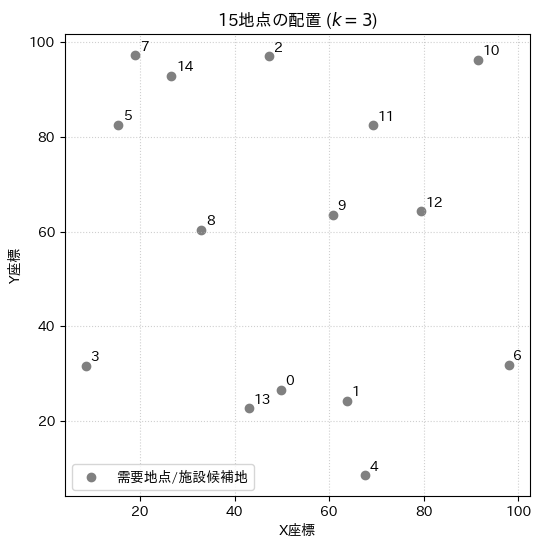

In [ ]:
#@title 地点のプロット (初期状態)
plt.figure(figsize=(6,6))
plt.scatter(locations_coords[:,0], locations_coords[:,1], c='gray', marker='o', label='需要地点/施設候補地')
for i in range(num_locations):
    plt.text(locations_coords[i,0]+1, locations_coords[i,1]+1, str(i))
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title(f"{num_locations}地点の配置 ($k={k_to_locate}$)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal')
plt.show()

### モデルの作成と変数の定義

決定変数は、

  * $y_j$: 施設建設候補地 $j \in J$ に施設を開設するならば $1$、
  そうでないならば $0$ をとるバイナリ変数。
  * $x_{ij}$: 需要地点 $i \in I$ を、施設建設候補地 $j \in J$ に開設された施設に割り当てるならば $1$、そうでないならば $0$ をとるバイナリ変数。


In [ ]:
# モデルの作成
model_kmed = mip.Model(name="k_median", sense=mip.MINIMIZE, solver_name=mip.CBC)

# インデックスの集合
I_nodes = range(num_locations) # 需要地点のインデックス
J_nodes = range(num_locations) # 施設候補地のインデックス (I_nodesと同じ)

# 変数の定義
# y_j: 施設候補地 j に施設を開設するなら1
y = [model_kmed.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in J_nodes]

# x_ij: 需要地点 i を施設 j に割り当てるなら1
x = {(i,j): model_kmed.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}")
     for i in I_nodes for j in J_nodes}

### 目的関数の設定

目的関数は、
全ての需要地点から、それぞれ割り当てられた施設までの総距離（または総コスト）であった。

$$\min \sum_{i \in I} \sum_{j \in J} d_{ij} x_{ij}$$

In [ ]:
# 目的関数の設定
model_kmed.objective = mip.xsum(dist_matrix_kmed[i,j] * x[(i,j)] for i in I_nodes for j in J_nodes)

### 制約条件の追加


1.  **割り当て制約**:
各需要地点 $i$ は、いずれか一つの施設 $j$ に割り当てられなければならない。
$$\sum_{j \in J} x_{ij} = 1 \quad \forall i \in I$$

2.  **施設開設連動制約**:
    需要地点 $i$ を施設候補地 $j$ に割り当てる ($x\_{ij}=1$) ことができるのは、その候補地 $j$ に実際に施設が開設されている ($y\_j=1$) 場合のみである。
    $$x_{ij} \le y_j \quad \forall i \in I, \forall j \in J$$
    もし $y\_j=0$ (施設 $j$ が開設されない) ならば、全ての $i$ について $x\_{ij}=0$ となり、需要地点 $i$ は施設 $j$ に割り当てられない。もし $y\_j=1$ ならば、$x\_{ij} \\le 1$ となり、割り当てが可能になる。

3.  **施設数制約**:
    開設される施設の総数は、指定された数 $k$ に等しくなければならない。
    $$\sum_{j \in J} y_j = k$$


In [ ]:
# 制約1: 各需要地点iは、いずれか一つの施設jに割り当てられる
for i in I_nodes:
    model_kmed += mip.xsum(x[(i,j)] for j in J_nodes) == 1, f"assign_cust_{i}"

# 制約2: 需要地点iは、施設jが開設されている場合にのみ割り当て可能
for i in I_nodes:
    for j in J_nodes:
        model_kmed += x[(i,j)] <= y[j], f"link_assign_open_{i}_{j}"

# 制約3: 開設する施設の総数は k 個
model_kmed += mip.xsum(y[j] for j in J_nodes) == k_to_locate, f"num_facilities_is_k"

### 問題の求解と結果の表示

In [ ]:
# 最適化の実行

# 地点数やkが増えると時間がかかることがあるため、制限時間を設ける
time_limit_kmed_sec = 600

status_kmed = model_kmed.optimize(max_seconds=time_limit_kmed_sec)

# 結果の表示
if status_kmed == mip.OptimizationStatus.OPTIMAL or status_kmed == mip.OptimizationStatus.FEASIBLE:
    if status_kmed == mip.OptimizationStatus.OPTIMAL:
        print(f"最適解が見つかりました！")
    else:
        print(f"実行可能解が見つかりました（最適ではない可能性あり）。")

    print(f"最小総割り当て距離: {model_kmed.objective_value:.2f}")

    opened_facilities = [j for j in J_nodes if y[j].x >= 0.99]
    print(f"\n開設された施設の位置 (インデックス): {opened_facilities}")

    assignments = {}
    for i in I_nodes:
        for j in J_nodes:
            if x[(i,j)].x >= 0.99:
                assignments[i] = j
                break
    print(f"各需要地点の割り当て先: {assignments}")

elif status_kmed == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。制約条件（特にkの値）を見直してください。")
elif status_kmed == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print(f"解が見つかりませんでした（時間制限: {time_limit_kmed_sec}秒）。")
else:
    print(f"最適化ステータス: {status_kmed}")

最適解が見つかりました！
最小総割り当て距離: 278.40

開設された施設の位置 (インデックス): [0, 12, 14]
各需要地点の割り当て先: {0: 0, 1: 0, 2: 14, 3: 0, 4: 0, 5: 14, 6: 12, 7: 14, 8: 14, 9: 12, 10: 12, 11: 12, 12: 12, 13: 0, 14: 14}


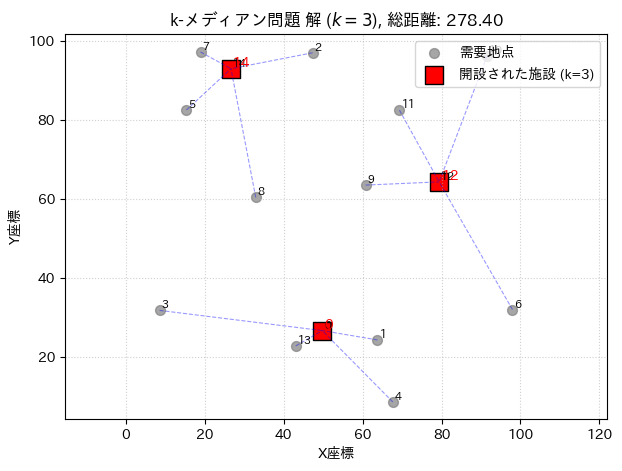

In [ ]:
#@title 結果の可視化
if status_kmed == mip.OptimizationStatus.OPTIMAL or status_kmed == mip.OptimizationStatus.FEASIBLE:
    opened_facilities = [j for j in J_nodes if y[j].x >= 0.99]
    assignments = {}
    for i in I_nodes:
        for j in J_nodes:
            if x[(i,j)].x >= 0.99:
                assignments[i] = j
                break

    # 結果の可視化
    plt.figure(figsize=(7,5))
    # 需要地点のプロット
    plt.scatter(locations_coords[:,0], locations_coords[:,1], c='gray', marker='o', label='需要地点', alpha=0.7, s=50)
    for i in I_nodes:
        plt.text(locations_coords[i,0]+0.5, locations_coords[i,1]+0.5, str(i), fontsize=8)

    # 開設された施設のプロット
    facility_plot_coords = locations_coords[opened_facilities,:]
    plt.scatter(facility_plot_coords[:,0], facility_plot_coords[:,1], c='red', marker='s', s=150, label=f'開設された施設 (k={k_to_locate})', edgecolors='black')
    for fac_idx in opened_facilities: # 施設にも番号表示
         plt.text(locations_coords[fac_idx,0]+0.5, locations_coords[fac_idx,1]+0.5, str(fac_idx), fontsize=10, color='red', weight='bold')


    # 割り当て線のプロット
    for i in I_nodes:
        assigned_j = assignments.get(i)
        if assigned_j is not None:
            plt.plot([locations_coords[i,0], locations_coords[assigned_j,0]],
                     [locations_coords[i,1], locations_coords[assigned_j,1]],
                     'b--', alpha=0.4, linewidth=0.8)

    plt.xlabel("X座標")
    plt.ylabel("Y座標")
    plt.title(f"k-メディアン問題 解 ($k={k_to_locate}$), 総距離: {model_kmed.objective_value:.2f}")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')
    plt.show()

elif status_kmed == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。制約条件（特にkの値）を見直してください。")
elif status_kmed == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print(f"解が見つかりませんでした（時間制限: {time_limit_kmed_sec}秒）。")
else:
    print(f"最適化ステータス: {status_kmed}")

### モデルの拡張と関連問題

k-メディアン問題は、施設配置問題の基本的なモデルの一つであり、様々な拡張や関連問題が存在する。

  * **容量制約付きk-メディアン問題 (Capacitated k-Median Problem)**:
    各施設が開設された場合に、対応できる需要量（顧客数や処理量など、
    demand$_i$）に上限（容量、Capacity$_j$）がある問題。この場合、割り当て制約がより複雑になる。
    
$$ \sum_{i \in I} \text{demand}_i \cdot x_{ij} \le \text{Capacity}_j \cdot y_j \quad \forall j \in J
$$

  * **固定費用施設配置問題 (Uncapacitated/Capacitated Facility Location Problem - UFLP/CFLP)**:
    各施設候補地 $j$ に施設を開設するための固定費用 $f\_j$ が設定されている。
    目的は、総割り当てコストと総施設開設費用の合計を最小化することになる。
    
    目的関数:
$$
\min (\sum_{i,j} d_{ij}x_{ij} + \sum_j f_j y_j)
$$

  * **ヒューリスティクス解法**:
    k-メディアン問題もNP困難であるため、大規模なインスタンスに対しては厳密解を求めるのが難しい。そのため、以下のようなヒューリスティクスが用いられる。

      * **Greedyアルゴリズム**: 1つずつ施設を追加していき、各ステップで総コストを最も改善する場所に施設を配置する。
      * **局所探索法**: 初期解から始めて、施設の場所を少しずつ変更したり、割り当てを変更したりして解を改善する（例: 頂点交換）。
      * **遺伝的アルゴリズム (GA)、タブー探索 (TS)、シミュレーテッドアニーリング (SA)** などのメタヒューリスティクス。

これらの拡張や関連問題を理解することで、より現実に即した複雑な施設配置問題に対応する能力が養われる。

---
#演習問題



##演習問題 1

例題と同じ15地点のデータを用い、開設する施設数 $k$ を $2$ に変更した場合の
総割当距離を解答せよ。

##演習問題 2

距離行列 $d_{ij}$ をユークリッド距離ではなく、
マンハッタン距離（$L_1$距離: $|x_i-x_j| + |y_i-y_j|$）に変更して、
例題のデータ ($k=3$) でk-メディアン問題を解き総割当距離を解答せよ。
なお、マンハッタン距離は
```
dist_matrix_manhattan = cdist(locations_coords, locations_coords, 'cityblock')
```
で計算できる。


##演習問題 3

例題のデータ ($k=3$) において、以下の追加制約を加えて最適化し、
総割当距離を解答せよ。

**追加条件：** 地点インデックス 8 に必ず施設を建設する。

##演習問題 4

例題のデータ ($k=3$) において、以下のの追加制約を加えて最適化し、
総割当距離を解答せよ。

**追加条件：** 地点インデックス 8 には施設を建設してはならない。


##演習問題 5

例題のデータ ($k=3$) において、各施設候補地 $j$ に施設を開設するためのコスト $f_j$ が別途かかるとする。ただし、

* $f_j = 500$、ただし  $j$ が偶数の場合
* $f_j = 200$、ただし  $j$ が奇数の場合

とする。この時、
「総割り当て距離と、開設された $k$ 個の施設の総開設コストの合計」
を最小化し、
最適な目的関数値を解答せよ。